# PROJECT

# Improving new credit card/loan applications approval process using Machine Learning

## Introduction

Machine Learning, ML is becoming an integral part of all modern organization.
In the finance setor, ML can be used to detect fraud, automate approval processes and trading activities, and provide financial advisory services to investors.

## Objectives of the Project
1. Automate approval process of new credit cards/loan applications
2. Provide web-based application interface for our customers
3. Provide instant feedback to customers
4. Collect new data for future system improvements

## Data Source
### Project uses an open-source dataset from Kaggle found on the link below
https://www.kaggle.com/rikdifos/credit-card-approval-prediction/tasks?taskId=1416

# Table of Contents
* Section 1: [Data Import](#data_import)
* Section 2: [Data Exploration](#data_exploration)
* Section 3: [Data Cleaning](#data_cleaning)
* Section 4: [Data Analysis](#data_analysis)
* Section 5: [First ML Model](#first_model)
* Section 6: [Data Visualization](#data_visualization)
* Section 7: [Records Data](#records_data)
* Section 8: [Eligibility ML Model](#eligibility_ml)
* Section 9: [Saving Model and Transformer](#model_tx)

In [1]:
# import the required libraries and modules
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score,accuracy_score,recall_score,f1_score,r2_score
from sklearn.metrics import confusion_matrix,plot_confusion_matrix

C:\Users\KIMERA\.conda\envs\data_engineering\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## <a name="data_import"> </a> Data Import

In [2]:
data = pd.read_csv("<path-to-file>\\application_record.csv")
data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [3]:
# Convert all columns to lower case
new_columns = []
for column in data.columns:
    new_columns.append(column.lower())
data.columns = new_columns

# Delete column list to save memory
del new_columns

data.head()

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,amt_income_total,name_income_type,name_education_type,name_family_status,name_housing_type,days_birth,days_employed,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


## <a name="data_exploration"> </a> Data Exploration

In [4]:
data.shape

(438557, 18)

In [5]:
data.dtypes

id                       int64
code_gender             object
flag_own_car            object
flag_own_realty         object
cnt_children             int64
amt_income_total       float64
name_income_type        object
name_education_type     object
name_family_status      object
name_housing_type       object
days_birth               int64
days_employed            int64
flag_mobil               int64
flag_work_phone          int64
flag_phone               int64
flag_email               int64
occupation_type         object
cnt_fam_members        float64
dtype: object

### We have int64, float64 and object data types

In [6]:
data.isna().sum()/len(data)

id                     0.00000
code_gender            0.00000
flag_own_car           0.00000
flag_own_realty        0.00000
cnt_children           0.00000
amt_income_total       0.00000
name_income_type       0.00000
name_education_type    0.00000
name_family_status     0.00000
name_housing_type      0.00000
days_birth             0.00000
days_employed          0.00000
flag_mobil             0.00000
flag_work_phone        0.00000
flag_phone             0.00000
flag_email             0.00000
occupation_type        0.30601
cnt_fam_members        0.00000
dtype: float64

#### Only one column ("occupation_type") has NaNs
#### Over 30% of values in the "occupation_type" column are NaN

## <a name="data_cleaning"> </a> Data cleaning

In [7]:
# Treating the null values in the "occupation_type" column
data["occupation_type"].unique()

array([nan, 'Security staff', 'Sales staff', 'Accountants', 'Laborers',
       'Managers', 'Drivers', 'Core staff', 'High skill tech staff',
       'Cleaning staff', 'Private service staff', 'Cooking staff',
       'Low-skill Laborers', 'Medicine staff', 'Secretaries',
       'Waiters/barmen staff', 'HR staff', 'Realty agents', 'IT staff'],
      dtype=object)

In [8]:
# Get the most common values in the "occupation_type" column
data["occupation_type"].value_counts(dropna=False)

NaN                      134203
Laborers                  78240
Core staff                43007
Sales staff               41098
Managers                  35487
Drivers                   26090
High skill tech staff     17289
Accountants               15985
Medicine staff            13520
Cooking staff              8076
Security staff             7993
Cleaning staff             5845
Private service staff      3456
Low-skill Laborers         2140
Secretaries                2044
Waiters/barmen staff       1665
Realty agents              1041
HR staff                    774
IT staff                    604
Name: occupation_type, dtype: int64

#### There are alomost twice (1.7) as many NaNs as the next highest occupation (Laborers)
#### We can not set the NaNs to the mode
#### I will build a ML model to predict the occupation of a customer and fill up the NaN

### Processing categorical columns
## NOTE: We are not using label or one-hot encoder because this model is to be used for online predictions. Users supply only ove values in a column and the map method does a better job than one-hot encoder. For label encoder, I only prefered the map method because of simplicity

In [9]:
# Get all categorical columns
categorical = data.select_dtypes(include=object)
categorical.head()

,code_gender,flag_own_car,flag_own_realty,name_income_type,name_education_type,name_family_status,name_housing_type,occupation_type
0,M,Y,Y,Working,Higher education,Civil marriage,Rented apartment,NaN
1,M,Y,Y,Working,Higher education,Civil marriage,Rented apartment,NaN
2,M,Y,Y,Working,Secondary / secondary special,Married,House / apartment,Security staff
3,F,N,Y,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff
4,F,N,Y,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,Sales staff


In [10]:
categorical.columns

Index(['code_gender', 'flag_own_car', 'flag_own_realty', 'name_income_type',
       'name_education_type', 'name_family_status', 'name_housing_type',
       'occupation_type'],
      dtype='object')

### Process code_gender column

In [11]:
data["code_gender"].unique()

array(['M', 'F'], dtype=object)

In [12]:
# column has only two values
# encode the values and confirm
data["code_gender"] = data["code_gender"].map({'F':0,'M':1})
data["code_gender"].unique()

array([1, 0], dtype=int64)

### Process flag_own_car column

In [13]:
data["flag_own_car"].unique()

array(['Y', 'N'], dtype=object)

In [14]:
# column has only two values
# encode the values and confirm
data["flag_own_car"] = data["flag_own_car"].map({'Y':1,'N':0})
data["flag_own_car"].unique()

array([1, 0], dtype=int64)

### Process flag_own_realty column

In [15]:
data["flag_own_realty"].unique()

array(['Y', 'N'], dtype=object)

In [16]:
# column has only two values
# encode the values and confirm
data["flag_own_realty"] = data["flag_own_realty"].map({'Y':1,'N':0})
data["flag_own_realty"].unique()

array([1, 0], dtype=int64)

### Process name_income_type column

In [17]:
data["name_income_type"].unique()

array(['Working', 'Commercial associate', 'Pensioner', 'State servant',
       'Student'], dtype=object)

In [18]:
# encode the values and confirm
dict_map = {'Working':1,'Commercial associate':2,'Pensioner':3,'State servant':4,'Student':5}
data["name_income_type"] = data["name_income_type"].map(dict_map)
data["name_income_type"].unique()

array([1, 2, 3, 4, 5], dtype=int64)

### Process name_education_type column

In [19]:
data["name_education_type"].unique()

array(['Higher education', 'Secondary / secondary special',
       'Incomplete higher', 'Lower secondary', 'Academic degree'],
      dtype=object)

In [20]:
# encode the values and confirm
dict_map = {'Academic degree':1,'Higher education':2,'Secondary / secondary special':3,'Incomplete higher':4,
            'Lower secondary':5}
data["name_education_type"] = data["name_education_type"].map(dict_map)
data["name_education_type"].unique()

array([2, 3, 4, 5, 1], dtype=int64)

### Process name_family_status column

In [21]:
data["name_family_status"].unique()

array(['Civil marriage', 'Married', 'Single / not married', 'Separated',
       'Widow'], dtype=object)

In [22]:
# encode the values and confirm
dict_map = {'Civil marriage':1,'Married':2,'Single / not married':3,'Separated':4,'Widow':5}
data["name_family_status"] = data["name_family_status"].map(dict_map)
data["name_family_status"].unique()

array([1, 2, 3, 4, 5], dtype=int64)

### Process name_housing_type column

In [23]:
data["name_housing_type"].unique()

array(['Rented apartment', 'House / apartment', 'Municipal apartment',
       'With parents', 'Co-op apartment', 'Office apartment'],
      dtype=object)

In [24]:
# encode the values and confirm
dict_map = {'Rented apartment':1,'House / apartment':2,'Municipal apartment':3,'With parents':4,'Co-op apartment':5,
           'Office apartment':6}
data["name_housing_type"] = data["name_housing_type"].map(dict_map)
data["name_housing_type"].unique()

array([1, 2, 3, 4, 5, 6], dtype=int64)

### Process occupation_type column

In [25]:
data["occupation_type"].unique()

array([nan, 'Security staff', 'Sales staff', 'Accountants', 'Laborers',
       'Managers', 'Drivers', 'Core staff', 'High skill tech staff',
       'Cleaning staff', 'Private service staff', 'Cooking staff',
       'Low-skill Laborers', 'Medicine staff', 'Secretaries',
       'Waiters/barmen staff', 'HR staff', 'Realty agents', 'IT staff'],
      dtype=object)

In [26]:
# Here, One-Hot encoder would have been a good choice but the final model shall be used for online prediction
# Not sure how One-Hot encoder will perform when only one value is given
# Map method seems like a better choice
# Map NaN to 0

dict_map={np.nan:0, 'Security staff':1, 'Sales staff':2, 'Accountants':3, 'Laborers':4,'Managers':5, 'Drivers':6,
          'Core staff':7, 'High skill tech staff':8,'Cleaning staff':9, 'Private service staff':10,'Cooking staff':11,
          'Low-skill Laborers':12, 'Medicine staff':13, 'Secretaries':14,'Waiters/barmen staff':15,'HR staff':16,
          'Realty agents':17, 'IT staff':18}
data["occupation_type"] = data["occupation_type"].map(dict_map)
data["occupation_type"].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18], dtype=int64)

In [27]:
data.dtypes

id                       int64
code_gender              int64
flag_own_car             int64
flag_own_realty          int64
cnt_children             int64
amt_income_total       float64
name_income_type         int64
name_education_type      int64
name_family_status       int64
name_housing_type        int64
days_birth               int64
days_employed            int64
flag_mobil               int64
flag_work_phone          int64
flag_phone               int64
flag_email               int64
occupation_type          int64
cnt_fam_members        float64
dtype: object

#### All Columns are now int and float types only

## <a name="data_analysis"> </a> Data Analysis

#### days_birth is given as negative values. Convert it to absolute values
#### Convert the days_birth column from days to years. Years are a more realistic reflection of one's age than number of days
#### Create a new column named "age_years"

In [28]:
data["age_years"] = round(np.abs(data["days_birth"])/356,0)
data["age_years"].head()

0    34.0
1    34.0
2    60.0
3    54.0
4    54.0
Name: age_years, dtype: float64

#### days_employed is indicated as negative. Convert them to absolute values
#### Months of employment are a more realistic reprsentation of employment duration than days
#### Members employed for more that 15 days are considered as employed for a full month
#### Less than 15 days are to be considered unemployed
#### We assume a month has 30 days

In [29]:
data["months_employed"] = np.ceil(np.abs(data["days_employed"])/30)
data["months_employed"].head()

0    152.0
1    152.0
2     38.0
3    102.0
4    102.0
Name: months_employed, dtype: float64

In [30]:
# drop "days_employed" and "days_birth" columns
data.drop(["days_employed","days_birth"], axis=1,inplace=True)

### Analyzing the amt_income_total column (Income of applicants) 

In [31]:
data['amt_income_total'].describe().T

count    4.385570e+05
mean     1.875243e+05
std      1.100869e+05
min      2.610000e+04
25%      1.215000e+05
50%      1.607805e+05
75%      2.250000e+05
max      6.750000e+06
Name: amt_income_total, dtype: float64

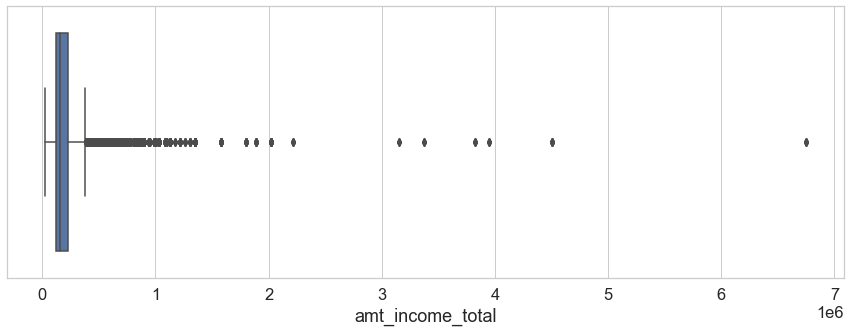

In [32]:
sns.set(rc={'figure.figsize':(15,5)}, font_scale=1.5, style='whitegrid')
ax = sns.boxplot(x=data['amt_income_total'])

### Observations
1. There are alot of outliers
2. Outliers are mostly on the upper side
3. In this dataset, the Median is a better measure of Central tedency than the Mean

### NOTE: We do not need to use the Mean of the amt_income_total column

# <a name="first_model"> </a> First ML model

### Normalize the numerical columns
### All our data is numerical. We already encoded the categorical columns

In [33]:
data.dtypes

id                       int64
code_gender              int64
flag_own_car             int64
flag_own_realty          int64
cnt_children             int64
amt_income_total       float64
name_income_type         int64
name_education_type      int64
name_family_status       int64
name_housing_type        int64
flag_mobil               int64
flag_work_phone          int64
flag_phone               int64
flag_email               int64
occupation_type          int64
cnt_fam_members        float64
age_years              float64
months_employed        float64
dtype: object

### Drop our target variable from data to be scaled
### Exclude all categorical columns from data to be scaled
### This is a classification problem not a regression (continous) problem. Scaling the target variable  will result into it being regarded as a countinous prediction by the ML model

In [34]:
# From our data analysis, Only three columns need scaling
final_data = data[['age_years','months_employed','amt_income_total']]
final_data.columns

Index(['age_years', 'months_employed', 'amt_income_total'], dtype='object')

In [35]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler().fit(final_data)
data_scaled = scaler.transform(final_data)
data_scaled = pd.DataFrame(data_scaled, columns = final_data.columns)
data_scaled.head()

,age_years,months_employed,amt_income_total
0,0.26,0.012403,0.059697
1,0.26,0.012403,0.059697
2,0.78,0.003039,0.012850
3,0.66,0.008296,0.036274
4,0.66,0.008296,0.036274


In [36]:
# drop the scaled column from original data
data = data.drop(['age_years','months_employed','amt_income_total'], axis=1)
data.columns

Index(['id', 'code_gender', 'flag_own_car', 'flag_own_realty', 'cnt_children',
       'name_income_type', 'name_education_type', 'name_family_status',
       'name_housing_type', 'flag_mobil', 'flag_work_phone', 'flag_phone',
       'flag_email', 'occupation_type', 'cnt_fam_members'],
      dtype='object')

#### Combine the Scaled and unscaled data into new dataframe

In [37]:
final_data_scaled = pd.concat([data,data_scaled],axis=1)
final_data_scaled.head()

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,name_income_type,name_education_type,name_family_status,name_housing_type,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,age_years,months_employed,amt_income_total
0,5008804,1,1,1,0,1,2,1,1,1,1,0,0,0,2.0,0.26,0.012403,0.059697
1,5008805,1,1,1,0,1,2,1,1,1,1,0,0,0,2.0,0.26,0.012403,0.059697
2,5008806,1,1,1,0,1,3,2,2,1,0,0,0,1,2.0,0.78,0.003039,0.012850
3,5008808,0,0,1,0,2,3,3,2,1,0,1,1,2,1.0,0.66,0.008296,0.036274
4,5008809,0,0,1,0,2,3,3,2,1,0,1,1,2,1.0,0.66,0.008296,0.036274


### Seperate our data into the null_dataset and not_null_dataset
### Use the not_null_dataset to train and test our model
### Predict the "occupation_type" values in the null_dataset

## NOTE: We mapped all our NaN to zero

In [38]:
null_dataset = final_data_scaled[final_data_scaled["occupation_type"] == 0]
null_dataset.shape

(134203, 18)

In [39]:
null_dataset.head()

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,name_income_type,name_education_type,name_family_status,name_housing_type,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,age_years,months_employed,amt_income_total
0,5008804,1,1,1,0,1,2,1,1,1,1,0,0,0,2.0,0.26,0.012403,0.059697
1,5008805,1,1,1,0,1,2,1,1,1,1,0,0,0,2.0,0.26,0.012403,0.059697
7,5008812,0,0,1,0,3,2,4,2,1,0,0,0,0,1.0,0.84,1.000000,0.038281
8,5008813,0,0,1,0,3,2,4,2,1,0,0,0,0,1.0,0.84,1.000000,0.038281
9,5008814,0,0,1,0,3,2,4,2,1,0,0,0,0,1.0,0.84,1.000000,0.038281


In [40]:
not_null_dataset = final_data_scaled[~(final_data_scaled["occupation_type"] == 0)]
not_null_dataset.shape

(304354, 18)

In [41]:
not_null_dataset.head()

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,name_income_type,name_education_type,name_family_status,name_housing_type,flag_mobil,flag_work_phone,flag_phone,flag_email,occupation_type,cnt_fam_members,age_years,months_employed,amt_income_total
2,5008806,1,1,1,0,1,3,2,2,1,0,0,0,1,2.0,0.78,0.003039,0.012850
3,5008808,0,0,1,0,2,3,3,2,1,0,1,1,2,1.0,0.66,0.008296,0.036274
4,5008809,0,0,1,0,2,3,3,2,1,0,1,1,2,1.0,0.66,0.008296,0.036274
5,5008810,0,0,1,0,2,3,3,2,1,0,1,1,2,1.0,0.66,0.008296,0.036274
6,5008811,0,0,1,0,2,3,3,2,1,0,1,1,2,1.0,0.66,0.008296,0.036274


In [42]:
# our target variable
y = not_null_dataset["occupation_type"]
X = not_null_dataset.drop(["occupation_type",'id'], axis=1)

### Randomise the data

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

### USE DecisionTreeClassifier. It has the best result (accuracy > 95%)


In [44]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
clf = DecisionTreeClassifier(random_state=0)
#iris = load_iris()
cross_val_score(clf, X_train, y_train, cv=10)

array([0.95116843, 0.95342725, 0.9541665 , 0.95239855, 0.95297355,
       0.95120749, 0.95473961, 0.95198784, 0.94985214, 0.95276819])

### Then the magic of .fit() and .predict()

In [45]:
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [46]:
y_pred

array([ 2,  8,  2, ..., 13,  4,  6], dtype=int64)

In [47]:
from sklearn.metrics import mean_squared_error,accuracy_score
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE: %f" % (rmse))

RMSE: 1.019709


In [48]:
accuracy_score(y_test, y_pred)

0.9611637725682181

In [49]:
df = pd.DataFrame({"test":y_test,"predictions":y_pred})
df.head(5)

,test,predictions
64673,2,2
169571,8,8
22359,2,2
105158,5,5
180742,8,8


## Predict the missing occupation
## data is already scaled

In [50]:
null_dataset.shape

(134203, 18)

In [51]:
# drop the "occupation_type" column and we replace it with our predictions
new_null_dataset = null_dataset.drop(["occupation_type",'id'], axis=1)
new_pred = clf.predict(new_null_dataset)
print(len(new_pred))
new_pred[:30]

134203


array([ 5,  5,  7,  7,  7, 11, 11, 11, 11,  4,  4,  4,  4,  4,  4,  4,  4,
        8,  8,  8,  8,  8,  8,  8,  5,  5,  5,  5,  5,  5], dtype=int64)

In [52]:
new_null_dataset.shape

(134203, 16)

In [53]:
null_dataset = null_dataset.drop('occupation_type', axis=1)
null_dataset.insert(10,'occupation_type', new_pred)

In [54]:
print(null_dataset.shape)
null_dataset.isna().sum()

(134203, 18)


id                     0
code_gender            0
flag_own_car           0
flag_own_realty        0
cnt_children           0
name_income_type       0
name_education_type    0
name_family_status     0
name_housing_type      0
flag_mobil             0
occupation_type        0
flag_work_phone        0
flag_phone             0
flag_email             0
cnt_fam_members        0
age_years              0
months_employed        0
amt_income_total       0
dtype: int64

### Confirm no more null values

In [55]:
null_dataset[null_dataset['occupation_type'].isna()].shape

(0, 18)

### Combine both the null_dataset and not_null_dataset into one Dataframe

In [56]:
data = pd.concat([null_dataset,not_null_dataset], axis=0)
data.head()

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,name_income_type,name_education_type,name_family_status,name_housing_type,flag_mobil,occupation_type,flag_work_phone,flag_phone,flag_email,cnt_fam_members,age_years,months_employed,amt_income_total
0,5008804,1,1,1,0,1,2,1,1,1,5,1,0,0,2.0,0.26,0.012403,0.059697
1,5008805,1,1,1,0,1,2,1,1,1,5,1,0,0,2.0,0.26,0.012403,0.059697
7,5008812,0,0,1,0,3,2,4,2,1,7,0,0,0,1.0,0.84,1.000000,0.038281
8,5008813,0,0,1,0,3,2,4,2,1,7,0,0,0,1.0,0.84,1.000000,0.038281
9,5008814,0,0,1,0,3,2,4,2,1,7,0,0,0,1.0,0.84,1.000000,0.038281


In [57]:
data.isna().sum()

id                     0
code_gender            0
flag_own_car           0
flag_own_realty        0
cnt_children           0
name_income_type       0
name_education_type    0
name_family_status     0
name_housing_type      0
flag_mobil             0
occupation_type        0
flag_work_phone        0
flag_phone             0
flag_email             0
cnt_fam_members        0
age_years              0
months_employed        0
amt_income_total       0
dtype: int64

## No more null values in the dataset. Wuhu..................

#### Check if the dataframe shape is the same as our original dataframe
#### In our case, both dataframes have the same shape

In [58]:
data.shape

(438557, 18)

# <a name="data_visualization"> </a> Data Visualization

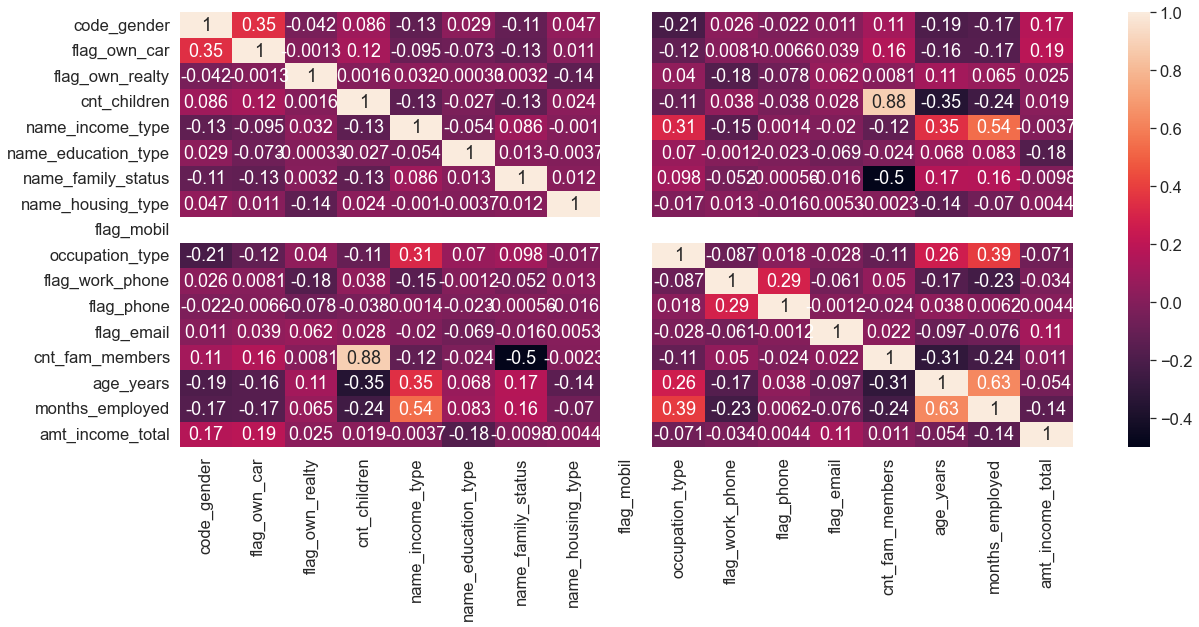

In [59]:
visual_data = data.drop('id', axis=1)
corr_matrix= visual_data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(20, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

# <a name="records_data"> </a> Records Data

In [60]:
credit = pd.read_csv("<path-to-file>\\credit_record.csv")
credit.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [61]:
# change column names to lower case
cols = []
for column in credit.columns:
    cols.append(column.lower())
    
credit.columns = cols
del cols
credit.columns

Index(['id', 'months_balance', 'status'], dtype='object')

In [62]:
# CHECK FOR NaN
credit.isna().sum()/len(credit)

id                0.0
months_balance    0.0
status            0.0
dtype: float64

## There are no NaNs. Wuhu...........

In [63]:
# FROM THE DATA DESCRIPTION

#     0: 1-29 days past due 
#     1: 30-59 days past due 
#     2: 60-89 days overdue 
#     3: 90-119 days overdue 
#     4: 120-149 days overdue 
#     5: Overdue or bad debts, write-offs for more than 150 days 
#     C: paid off that month 
#     X: No loan for the month


## European banks nomally charge customers if they are loan are over due by 60 days
#### Linkhttps://www.bankbazaar.com/credit-card/reasons-why-you-should-avoid-late-credit-card-payments.h 
## I will consider 30-59 days as defaulting

In [64]:
# New Categorisation:

# 0: No loan X
# 1: paid off C
# 2: 1-29 days past due 0 
# 3: 30-59 days past due 1
# 4: 60-89 days overdue 2
# 5: 90-119 days overdue 3
# 6: 120-149 days overdue 4 
# 7: Overdue or bad debts, write-offs for more than 150 day 5


In [65]:
credit["status"] = credit["status"].map({"X": "0", "C": "1",'0':'2','1':'3','2':'4','3':'5','4':'6','5':'7'})
credit["status"] .head()

0    0
1    2
2    2
3    2
4    1
Name: status, dtype: object

In [66]:
# Check data types
credit.dtypes

id                 int64
months_balance     int64
status            object
dtype: object

In [67]:
# convert "status" column to numeric
credit["status"] = credit["status"].astype(int)
credit.dtypes

id                int64
months_balance    int64
status            int32
dtype: object

### Every customer whose loan is either cleared or late by less than 59 days, we approve the application
### Create a new column "creteria" with two categories. 1 - Approved and 0 - Denied

In [68]:
# Creating a new column with the criterion
credit['criteria'] = np.where(credit['status'] < 3, 1,0)
credit.head()

,id,months_balance,status,criteria
0,5001711,0,0,1
1,5001711,-1,2,1
2,5001711,-2,2,1
3,5001711,-3,2,1
4,5001712,0,1,1


In [69]:
credit.shape

(1048575, 4)

### Credit dataframe has a different shape to the application dataframe
### Checking for duplicates
### There are only 45,985 customers (unique ids)

In [70]:
credit['id'].nunique()

45985

In [71]:
credit['id'].isna().sum()

0

### I sort the column by individual ID and then take the mean of all the approval values. 
### If an ID has an overdue payment, the mean of approval is < 1.
### Anyone with a mean lower than one is not eligible (Every member with an overdue payment is not eligible for a new credit card/loan)

In [72]:
# Filter out only column we need
approval = credit[['id','criteria']]
approval.head()

,id,criteria
0,5001711,1
1,5001711,1
2,5001711,1
3,5001711,1
4,5001712,1


In [73]:
# as_index=False tells pandas not to set the groupby column as an index but leave it as a column
check_approval = approval.groupby('id',as_index=False,).mean()
check_approval.head()

,id,criteria
0,5001711,1.0
1,5001712,1.0
2,5001713,1.0
3,5001714,1.0
4,5001715,1.0


In [74]:
check_approval[check_approval['criteria'] != 1].head(10)

,id,criteria
6,5001718,0.948718
8,5001720,0.805556
35,5001757,0.952381
57,5001786,0.983051
63,5001792,0.880000
64,5001793,0.740741
78,5001816,0.916667
79,5001817,0.818182
94,5001836,0.947368
102,5001844,0.979167


In [75]:
# Creating the final column for eligibility
# if criterial ==1, eligibility =1
# else if criteria <1, eligibility is zero
check_approval['eligibility'] = np.where(check_approval['criteria'] == 1, 1,0)
check_approval.head()

,id,criteria,eligibility
0,5001711,1.0,1
1,5001712,1.0,1
2,5001713,1.0,1
3,5001714,1.0,1
4,5001715,1.0,1


In [76]:
check_approval = check_approval[['id','eligibility']]
check_approval.head()

,id,eligibility
0,5001711,1
1,5001712,1
2,5001713,1
3,5001714,1
4,5001715,1


In [77]:
## Merge the records DF and the cistomer details DF

In [78]:
final_approval = pd.merge(data, check_approval, on = 'id', how = 'inner')
final_approval.head(10)

,id,code_gender,flag_own_car,flag_own_realty,cnt_children,name_income_type,name_education_type,name_family_status,name_housing_type,flag_mobil,occupation_type,flag_work_phone,flag_phone,flag_email,cnt_fam_members,age_years,months_employed,amt_income_total,eligibility
0,5008804,1,1,1,0,1,2,1,1,1,5,1,0,0,2.0,0.26,0.012403,0.059697,0
1,5008805,1,1,1,0,1,2,1,1,1,5,1,0,0,2.0,0.26,0.012403,0.059697,0
2,5008812,0,0,1,0,3,2,4,2,1,7,0,0,0,1.0,0.84,1.000000,0.038281,1
3,5008813,0,0,1,0,3,2,4,2,1,7,0,0,0,1.0,0.84,1.000000,0.038281,1
4,5008814,0,0,1,0,3,2,4,2,1,7,0,0,0,1.0,0.84,1.000000,0.038281,1
5,5008834,0,0,1,1,1,3,3,2,1,11,0,0,0,2.0,0.20,0.004354,0.012850,1
6,5008835,0,0,1,1,1,3,3,2,1,11,0,0,0,2.0,0.20,0.004354,0.012850,1
7,5008884,0,0,1,0,3,3,5,2,1,11,0,0,0,1.0,0.72,1.000000,0.042966,1
8,5008951,1,0,1,1,1,3,2,2,1,4,0,0,0,3.0,0.16,0.007639,0.029581,1
9,5008952,1,0,1,1,1,3,2,2,1,4,0,0,0,3.0,0.16,0.007639,0.029581,1


In [79]:
# rename columns
final_approval.columns

Index(['id', 'code_gender', 'flag_own_car', 'flag_own_realty', 'cnt_children',
       'name_income_type', 'name_education_type', 'name_family_status',
       'name_housing_type', 'flag_mobil', 'occupation_type', 'flag_work_phone',
       'flag_phone', 'flag_email', 'cnt_fam_members', 'age_years',
       'months_employed', 'amt_income_total', 'eligibility'],
      dtype='object')

In [80]:
rename_dict = {'code_gender':'gender','flag_own_car':'own_car','flag_own_realty':'property_owner','cnt_children':'no_of_children','cnt_fam_members':
'no_of_dependants','name_family_status':'marital_status','name_housing_type':'housing_type','flag_mobil':'mobile',
 'flag_work_phone':'work_phone','flag_email':'email','name_education_type':'education_level',
 'name_education_type':'level_of_education','name_income_type':'income_type','amt_income_total':'income'}
final_approval = final_approval.rename(columns=rename_dict)
final_approval.columns

Index(['id', 'gender', 'own_car', 'property_owner', 'no_of_children',
       'income_type', 'level_of_education', 'marital_status', 'housing_type',
       'mobile', 'occupation_type', 'work_phone', 'flag_phone', 'email',
       'no_of_dependants', 'age_years', 'months_employed', 'income',
       'eligibility'],
      dtype='object')

In [81]:
final_approval.isna().sum()/len(final_approval)

id                    0.0
gender                0.0
own_car               0.0
property_owner        0.0
no_of_children        0.0
income_type           0.0
level_of_education    0.0
marital_status        0.0
housing_type          0.0
mobile                0.0
occupation_type       0.0
work_phone            0.0
flag_phone            0.0
email                 0.0
no_of_dependants      0.0
age_years             0.0
months_employed       0.0
income                0.0
eligibility           0.0
dtype: float64

In [82]:
# drop flag phone column as we already have mobile and work phones column
final_approval = final_approval.drop('flag_phone', axis=1)

In [83]:
# check data types
# We dont want any object types. We already did transformations
final_approval.dtypes

id                      int64
gender                  int64
own_car                 int64
property_owner          int64
no_of_children          int64
income_type             int64
level_of_education      int64
marital_status          int64
housing_type            int64
mobile                  int64
occupation_type         int64
work_phone              int64
email                   int64
no_of_dependants      float64
age_years             float64
months_employed       float64
income                float64
eligibility             int32
dtype: object

In [84]:
# Reorganize our pandas dataframe column in a sequence that would make sense on a user-facing form
final_approval = final_approval[['id','gender','age_years','marital_status','no_of_children','no_of_dependants',
            'level_of_education','income_type','occupation_type','housing_type','property_owner','mobile','work_phone','email',
                                 'months_employed','income','eligibility']]
final_approval.columns

Index(['id', 'gender', 'age_years', 'marital_status', 'no_of_children',
       'no_of_dependants', 'level_of_education', 'income_type',
       'occupation_type', 'housing_type', 'property_owner', 'mobile',
       'work_phone', 'email', 'months_employed', 'income', 'eligibility'],
      dtype='object')

In [85]:
final_approval.head()

,id,gender,age_years,marital_status,no_of_children,no_of_dependants,level_of_education,income_type,occupation_type,housing_type,property_owner,mobile,work_phone,email,months_employed,income,eligibility
0,5008804,1,0.26,1,0,2.0,2,1,5,1,1,1,1,0,0.012403,0.059697,0
1,5008805,1,0.26,1,0,2.0,2,1,5,1,1,1,1,0,0.012403,0.059697,0
2,5008812,0,0.84,4,0,1.0,2,3,7,2,1,1,0,0,1.000000,0.038281,1
3,5008813,0,0.84,4,0,1.0,2,3,7,2,1,1,0,0,1.000000,0.038281,1
4,5008814,0,0.84,4,0,1.0,2,3,7,2,1,1,0,0,1.000000,0.038281,1


## <a name="eligibility_ml"> </a> Eligibility ML model

### There is a massive imbalance in our target variable
### I use SMOTE to treat the imbalance

In [86]:
final_approval['eligibility'].value_counts()

1    32166
0     4291
Name: eligibility, dtype: int64

C:\Users\KIMERA\.conda\envs\data_engineering\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\KIMERA\.conda\envs\data_engineering\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[10:47:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
score:  0.8984358301758477
accuracy: 0.8807025724722157
precision:  0.8473096737263881
recall:  0.9267491000156519
f1:  0.8852508036181507
RMSE :  0.34539459684219764


C:\Users\KIMERA\.conda\envs\data_engineering\lib\site-packages\xgboost\data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


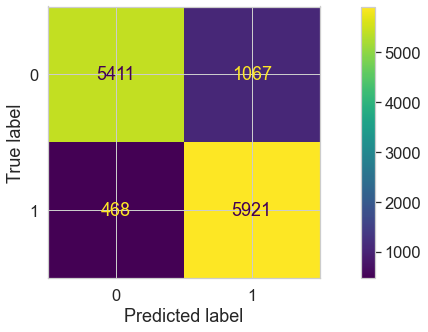

In [87]:
# XGB Classifier with SMOTE balancing has shown the best results
# the id column is nolonger needed
X = final_approval.drop(['eligibility','id'],axis=1)
y = final_approval['eligibility']

sm = SMOTE(random_state=69,k_neighbors=4)
X_SMOTE,y_SMOTE = sm.fit_resample(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_SMOTE, y_SMOTE, test_size = 0.2, random_state=37)

xgbc = XGBClassifier()

xgbc.fit(X_train, y_train)
score = xgbc.score(X_train, y_train)
y_pred = xgbc.predict(X_test)

RMSE = mean_squared_error(y_test, y_pred, squared=False)

print('score: ', score)
print('accuracy:', accuracy_score(y_test, y_pred))
print("precision: ",precision_score(y_test,y_pred))
print("recall: ",recall_score(y_test,y_pred))
print("f1: ",f1_score(y_test,y_pred))
print('RMSE : ', RMSE)
plot_confusion_matrix(xgbc, X_test, y_test)  
plt.show()

## <a name="model_tx"> </a> Saving ML model and Transformer

#### Save our model

In [88]:
import pickle

# save the model to disk
filename = 'finalized_model.pkl'
pickle.dump(xgbc, open(filename, 'wb'))
 
#load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.8807025724722157


#### Save our Transformer

In [89]:
import joblib
joblib.dump(scaler, 'scaler.gz')
my_scaler = joblib.load('scaler.gz')

In [90]:
### TRAIN ANOTHER MODEL TO PROVIDE THE PROBABILITY OF DEFAULT
### USE THE 'criteria'  COLUMN FROM THE check_approval DATAFRAME AS YOUR TARGET
### BANK OFFICIAL ASKS FOR MORE INFORMATION